# Day 5  | First week task

### Group 10: Javier López Rodríguez / Lucía Sánchez González


- Load time lapse fluorescence data from Matlab file "task1.mat" that is in the main course folder. Data are stored in two matrices: x_norm contains trajectories and t is a time vector

In [1]:
#import necessary tools, please add yourself here whatever you think you might need to solve the task

#basics
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plotter
from scipy.fftpack import fft
from scipy.signal import find_peaks

data = sio.loadmat('./task1.mat')

x = np.transpose(data['x_norm'])
time = np.transpose(data['t'])


In [2]:
# removing any possible nan before doing anything else
x_not_nan = np.nan_to_num(x) # replace nan with 0

- Plot (with labels) example cell trajectories

In [3]:
def plot_example_cell_trajectories(x, time, num_cells):
    # Plots the first num_cells cell trajectories
    for i in range(num_cells):
        plotter.plot(time, x[:, i], linestyle = '--', label = 'Cell '+str(i))
    plotter.title('First {} cell trajectories'.format(num_cells))
    plotter.ylabel('fluorescence (a.u.)')
    plotter.xlabel('time (min)')
    plotter.legend();

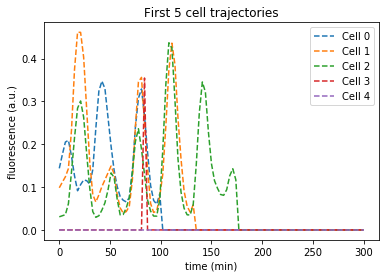

In [4]:
# using the function to plot the first 5 cell trajectories
plot_example_cell_trajectories(x_not_nan, time, 5)

- Find peaks in each trajectories using scipy library functions

In [5]:
def find_all_peaks(x):
    # returns a dictionary with the cell number as keys and the peaks' indexes as values
    peak_indexes = {} # cell number : array of peaks' indexes
    for cell in range(x.shape[1]): # for every cell
        peaks = find_peaks(x[:, cell])[0] # getting the array of indexes
        peak_indexes[cell] = peaks # storing it in the dictionary
    return peak_indexes
        

peak_indexes = find_all_peaks(x_not_nan) # calling the function

- Calculate amplitude and period of oscillations

In [6]:
def mean_amplitudes(x, peak_indexes):
    # computes the mean amplitude for each cell trajectory
    # if there are no peaks in a trajectory, that amplitude is 0
    
    # numpy array to store the mean amplitudes:
    mean_amp = np.zeros(x.shape[1]) 
    # calculating the mean amplitude for each cell:
    for cell in range(x.shape[1]): # for every cell
        cell_peaks_indexes = peak_indexes[cell] # array of indexes
        if cell_peaks_indexes.size != 0: # if there are any peaks
            # getting the amplitudes corresponding to the peaks
            amplitudes = x[cell_peaks_indexes, cell]
            mean_amplitude = np.mean(amplitudes)
            mean_amp[cell] = mean_amplitude # storing it
        # if there are no peaks, there is no maximum value,
        # so that entry in the array remains as 0.
    return mean_amp # returns the array of mean amplitudes

mean_amp = mean_amplitudes(x_not_nan, peak_indexes) # calling the function

In [7]:
def mean_periods(time, peak_indexes):
    # computes the mean period for each cell trajectory
    # if there are 0 or 1 peaks, we consider that period nan
    
    # creating a numpy array to store the mean periods:
    mean_per = np.zeros(len(peak_indexes.keys()))
    # calculating the mean period for each cell:
    for cell in range(len(peak_indexes.keys())): # for every cell
        cell_peaks_indexes = peak_indexes[cell] # array of indexes
        # we need at least two peaks to calculate the period:
        if cell_peaks_indexes.size >= 2: 
            peak_times = time[cell_peaks_indexes] # array of peaks' times
            ### calculating the periods from the peak times:
            # substracting every element minus the previous one
            peak_periods = peak_times[1:] - peak_times[:-1]
            mean_period = np.mean(peak_periods)
            mean_per[cell] = mean_period # storing it
        else: # if there are 0 or 1 peaks, there is no period between peaks
            mean_per[cell] = np.nan # np.nan denotes that there is no period
    return mean_per # returns the array of mean periods

mean_per = mean_periods(time, peak_indexes) # calling the function

- Draw histograms of period distribution

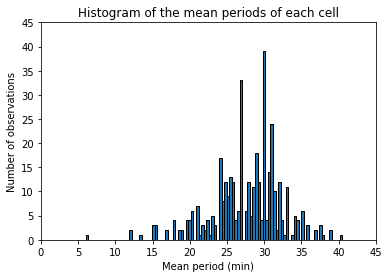

In [8]:
# plotting the histogram of the mean periods, excluding the nan values
# (because they represent cells with only 0 or 1 peak)
plotter.hist(mean_per[~np.isnan(mean_per)], bins = 100, edgecolor = "k")
plotter.title('Histogram of the mean periods of each cell')
plotter.xlabel('Mean period (min)')
plotter.ylabel('Number of observations')
plotter.axis([0, 45, 0, 45]);

- Plot amplitude vs period with labels 

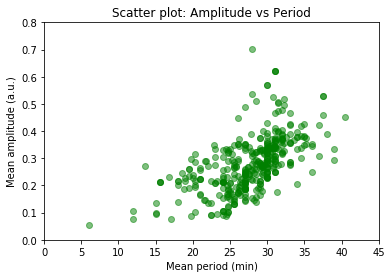

In [9]:
# Because we denoted that there is no period with np.nan,
# in order to represent amplitude vs period we will only
# represent the elements corresponding to a non-nan period.

non_nan_periods = mean_per[~np.isnan(mean_per)]
non_nan_amplitudes = mean_amp[~np.isnan(mean_per)]

# plotting a scatterplot of mean amplitudes vs mean periods
plotter.scatter(x = non_nan_periods, 
                y = non_nan_amplitudes, 
                marker = 'o', 
                color = 'g',
                alpha = 0.5)
plotter.title('Scatter plot: Amplitude vs Period')
plotter.xlabel('Mean period (min)')
plotter.ylabel('Mean amplitude (a.u.)')
plotter.axis([0, 45, 0, 0.8]);

- Select ten cell trajectories with the smallest periods and plot those as a heat map 

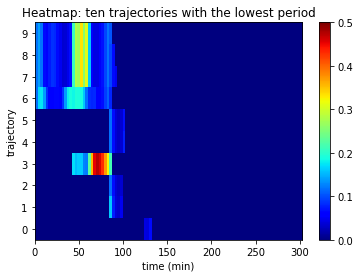

In [23]:
# Getting the indexes of the ten smallest periods:
lowest_per_indexes = np.argsort(mean_per)[:10]
# Getting the corresponding trajectories
trajectories = x_not_nan[:,lowest_per_indexes]

#plotting a heatmap of the ten trajectories with the smallest periods
plotter.imshow(trajectories.T, origin='lower', cmap='jet',
              extent = (0, 3*trajectories.shape[0], -0.5, 10-0.5),
              aspect = 'auto')
# we changed the extent so that the x axis goes from 0 to 300 instead of 100
# therefore representing time in minutes.
plotter.yticks(ticks = np.arange(10), labels = np.arange(10)) # getting the y axis to include every integer
plotter.colorbar()
plotter.clim(0,0.5)
plotter.title('Heatmap: ten trajectories with the lowest period')
plotter.xlabel('time (min)')
plotter.ylabel('trajectory');


- Perform frequency analysis using FFT Fourier transformation and identify a dominant frequency in the signal

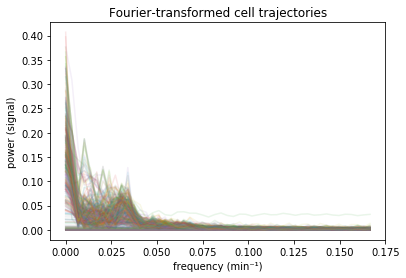

In [26]:
trajectories_fft = fft(x_not_nan, axis = 0) # fourier transform of each trajectory
# because each trajectory is one column of x_not_nan, we include axis = 0
T = time[1] - time[0] # sampling interval (minutes)
N = trajectories_fft.shape[0] # size

xf = np.linspace(0, 1.0/(2.0*T), N//2) # x-axis in frequencies
for cell in range(trajectories_fft.shape[1]): # for each cell
    plotter.plot(xf, 2.0/N * np.abs(trajectories_fft[0:N//2, cell]), alpha = 0.1)
    # using alpha = 0.1 so that we can distinguish where there are more lines
plotter.title('Fourier-transformed cell trajectories')
plotter.xlabel('frequency (min⁻¹)')
plotter.ylabel('power (signal)');

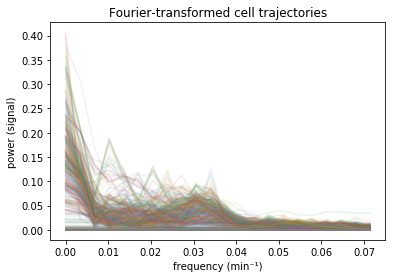

In [35]:
# in order to know better where the dominant frequency is/are,
# we plot the same plot from 0.000 to aprox 0.075 (x-axis)
# xf[21] == 0.07142857

for cell in range(trajectories_fft.shape[1]): # for each cell
    plotter.plot(xf[:22], 2.0/N * np.abs(trajectories_fft[:22, cell]), alpha = 0.1)
    # using alpha = 0.1 so that we can distinguish where there are more lines
plotter.title('Fourier-transformed cell trajectories')
plotter.xlabel('frequency (min⁻¹)')
plotter.ylabel('power (signal)');

The dominant frequency seems to be between 0.03 and 0.035 min⁻¹, which makes sense because in the scatter plot of mean amplitudes vs mean periods, most of the periods were between 25 and 30 min, and the corresponding frequencies would be 1/25 = 0.04 min⁻¹ and 1/30 = 0.033 min⁻¹.